### Начну сразу с результатов

* Наилучшей моделью для решения задачи будет модель SVD с точки зрения метрик HR и MRR
* Если судить по графикам, то выбор должен пасть на модели где K или Rank в районе значения '100'
* Проводя эксперименты (ниже в ноутбуке) я бы выбрал другие гиперпараметры, т.к. пытался отталкиваться еще от метрики RMSE. Пытался найти "золотую середину".
* Если сравнивать 2 подхода, то лучшим будет SVD, но при этом требовательным относительно железа и более долгим по SLA

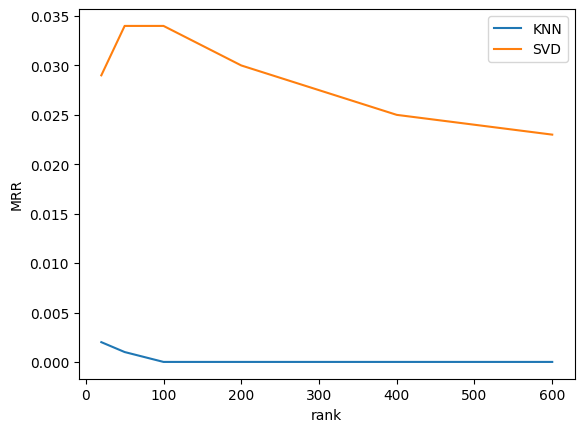

In [11]:
# Сравнение моделей по MMR

y = [0.002, 0.001, 0.000, 0.000, 0.000, 0.000]
y2 = [0.029, 0.034, 0.034, 0.030, 0.025, 0.023]
x = [20, 50, 100, 200, 400, 600]

fig, ax = plt.subplots()

ax.plot(x, y, label = 'KNN')
ax.plot(x, y2, label = 'SVD')
ax.set_xlabel('rank')
ax.set_ylabel('MRR');
plt.legend()
plt.show()

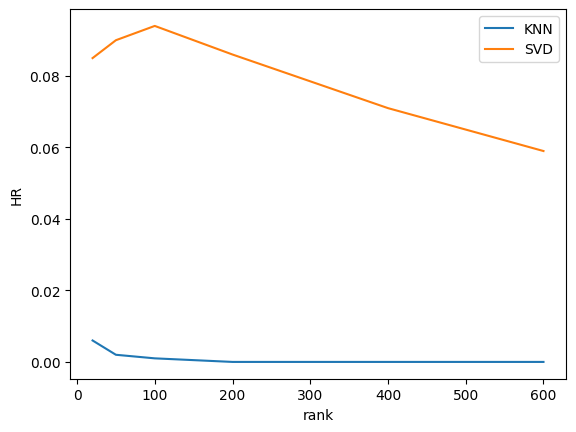

In [10]:
# Сравнение моделей по HR

import matplotlib.pyplot as plt

y = [0.006, 0.002, 0.001, 0.000, 0.000, 0.000]
y2 = [0.085, 0.090, 0.094, 0.086, 0.071, 0.059]
x = [20, 50, 100, 200, 400, 600]

fig, ax = plt.subplots()

ax.plot(x, y, label = 'KNN')
ax.plot(x, y2, label = 'SVD')
ax.set_xlabel('rank')
ax.set_ylabel('HR');
plt.legend()
plt.show()

### Эксперименты

### Модель KNN item-based

In [1]:
import os
username = 'recspert'
repo = 'Recommender-Systems-Intro-Sber-2023'

# remove local directory if it already exists
if os.path.isdir(repo):
    !rm -rf {repo}

!git clone https://github.com/{username}/{repo}.git

Cloning into 'Recommender-Systems-Intro-Sber-2023'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 32 (delta 12), reused 20 (delta 6), pack-reused 0
Unpacking objects: 100% (32/32), 184.20 KiB | 1.57 MiB/s, done.


In [2]:
!pip install --no-cache-dir --upgrade git+https://github.com/evfro/polara.git@develop#egg=polara

  Cloning https://github.com/evfro/polara.git (to revision develop) to /tmp/pip-install-cljrevak/polara_2142429e4e8b4df28382406541db3982
  Running command git clone --filter=blob:none --quiet https://github.com/evfro/polara.git /tmp/pip-install-cljrevak/polara_2142429e4e8b4df28382406541db3982
  Running command git checkout -b develop --track origin/develop
  Switched to a new branch 'develop'
  Branch 'develop' set up to track remote branch 'develop' from 'origin'.
  Resolved https://github.com/evfro/polara.git to commit 8e48cfd88e616ca53f8bbda1702a3e2c8abaf38e
  Preparing metadata (setup.py) ... done
  Created wheel for polara: filename=polara-0.7.2.dev0-py3-none-any.whl size=89447 sha256=d6d187b1e00a63ee24935b0f3a26920462aa2ba2b3b6b11402546a78ba571359
  Stored in directory: /tmp/pip-ephem-wheel-cache-vmqilph6/wheels/3f/3a/1f/42058978e585b23c384652846b96b72870f3c8c12976cdac50
Successfully built polara


In [3]:
import numpy as np
from scipy.sparse import coo_matrix, diags, csr_matrix
from scipy.sparse.linalg import norm as spnorm

from polara import get_movielens_data
from polara.preprocessing.dataframes import leave_one_out, reindex

# navigating to cloned repo directory in Colab
%cd {repo}
from dataprep import transform_indices
from evaluation import topn_recommendations, model_evaluate, downvote_seen_items
# restoring original location
%cd -

/content/Recommender-Systems-Intro-Sber-2023
/content


In [4]:
data = get_movielens_data(include_time=True)
training_, holdout_ = leave_one_out(data, target='timestamp', sample_top=True, random_state=0)
training_.head(5)

,userid,movieid,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [5]:
 holdout_.head(3)

,userid,movieid,rating,timestamp
324593,1922,506,4,978163419
818775,4918,1617,3,968087239
148613,957,1260,4,980731400


In [6]:
holdout_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6040 entries, 324593 to 735852
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   userid     6040 non-null   int64
 1   movieid    6040 non-null   int64
 2   rating     6040 non-null   int64
 3   timestamp  6040 non-null   int64
dtypes: int64(4)
memory usage: 235.9 KB


In [7]:
training, data_index = transform_indices(training_, 'userid', 'movieid')
holdout = reindex(holdout_, data_index.values(), filter_invalid=True)
holdout = holdout.sort_values('userid')
holdout.info()

Filtered 2 invalid observations.
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6038 entries, 25 to 1000042
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   userid     6038 non-null   int64
 1   movieid    6038 non-null   int64
 2   rating     6038 non-null   int64
 3   timestamp  6038 non-null   int64
dtypes: int64(4)
memory usage: 235.9 KB


In [8]:
data_description = dict(
    users = data_index['users'].name,
    items = data_index['items'].name,
    feedback = 'rating',
    n_users = len(data_index['users']),
    n_items = len(data_index['items']),
    test_users = holdout[data_index['users'].name].drop_duplicates().values
)
data_description

{'users': 'userid',
 'items': 'movieid',
 'feedback': 'rating',
 'n_users': 6040,
 'n_items': 3704,
 'test_users': array([   0,    1,    2, ..., 6037, 6038, 6039])}

In [9]:
holdout[data_index['users'].name].drop_duplicates().values

array([   0,    1,    2, ..., 6037, 6038, 6039])

In [10]:
userid = data_description['users']
seen_data = training.loc[lambda x: x[userid].isin(data_description["test_users"])]

In [13]:
def cosine_similarity(matrix):
    row_norm = spnorm(matrix, axis=1).squeeze()
    inv_norm = np.divide(1., row_norm, where=row_norm>0)
    matrix_normed = diags(inv_norm).dot(matrix)
    similarity = matrix_normed.dot(matrix_normed.T)
    similarity.setdiag(0)
    similarity.eliminate_zeros()
    return similarity.tocsr()

In [11]:
def build_naive_iknn_model(config, data, data_description):
    # get indices of observed data
    user_idx = data[data_description['users']].values
    item_idx = data[data_description['items']].values
    relscore = data[data_description['feedback']].values
    # construct rating matrix
    shape = (data_description['n_users'], data_description['n_items'])
    user_item_mtx = coo_matrix((relscore, (user_idx, item_idx)), shape=shape)
    # compute similarity matrix and normalization coefficients
    item_similarity_ = cosine_similarity(user_item_mtx.T)
    item_similarity = truncate_similarity(item_similarity_, config['K'])
    return user_item_mtx.tocsr(), item_similarity


def truncate_similarity(similarity, k):
    similarity = similarity.tocsr()
    inds = similarity.indices
    ptrs = similarity.indptr
    data = similarity.data
    new_ptrs = [0]
    new_inds = []
    new_data = []
    for i in range(len(ptrs)-1):
        start, stop = ptrs[i], ptrs[i+1]
        if start < stop:
            data_chunk = data[start:stop]
            topk = min(len(data_chunk), k)
            idx = np.argpartition(data_chunk, -topk)[-topk:]
            new_data.append(data_chunk[idx])
            new_inds.append(inds[idx+start])
            new_ptrs.append(new_ptrs[-1]+len(idx))
        else:
            new_ptrs.append(new_ptrs[-1])
    new_data = np.concatenate(new_data)
    new_inds = np.concatenate(new_inds)
    truncated = csr_matrix(
        (new_data, new_inds, new_ptrs),
        shape=similarity.shape
    )
    return truncated


def naive_iknn_model_scoring(params, testset, testset_description, weighting_scheme=None):
    user_item_mtx, item_similarity = params
    test_users = testset_description['test_users']
    if weighting_scheme is None: # no weighting
        scores = user_item_mtx[test_users].dot(item_similarity.T)
    elif isinstance(weighting_scheme, str):
        if weighting_scheme.startswith('el'):  # element-wise, ASt / BSt
            scores_unweighted = user_item_mtx[test_users].dot(item_similarity.T)
            weights_data = (user_item_mtx[test_users] != 0).dot(item_similarity.T)
            weights_data.eliminate_zeros()
            weights = weights_data._with_data(1. / weights_data.data)
            scores = scores_unweighted.multiply(weights)
        elif weighting_scheme.startswith('row'):# row-wise, AStD
            weights_data = item_similarity.sum(axis=1).A.squeeze()
            weights = diags(np.divide(1., weights_data, where=weights_data!=0))
            scores = user_item_mtx[test_users].dot(item_similarity.T.dot(weights))
        elif weighting_scheme.startswith('col'): # column-wise, ADSt
            weights_data = item_similarity.sum(axis=1).A.squeeze()
            weights = diags(np.divide(1., weights_data, where=weights_data!=0))
            scores = user_item_mtx[test_users].dot(weights.dot(item_similarity.T))
        else:
            raise ValueError('Unrecognized weighting scheme')
    else:
        raise ValueError('Unrecognized weighting scheme')
    return scores.A


### **Выводы по итогам экспериментов для KNN**

Для выбора оптимальной меры K я провел несколько экспериментов с увеличением значения.
По итогам эксперимента выбрал K = 50 , т.к. при других значениях уменьшается Cov (покрытие пользователей). Интересным наблюдением для было, что при уменьшении Cov уменьшается и RMSE.

Сделал для себя вывод о том, что наилучшим вариантом будет средние относительно относительно других экспериментов значения, а также не нулевое значение HR и MRR

При проведении экспериментов с меньшим, чем K = 50 значениями значительно увеличивается RMSE

* K = 20, HR = 0.006, MRR = 0.002, COV = 0.878, RMSE = **2.244**
* #### **K = 50, HR = 0.002, MRR = 0.001, COV = 0.964, RMSE = 1.427**
* K = 100, HR = 0.001, MRR = 0.000, COV = 0.992, RMSE = 1.214
* K = 200, HR = 0.000, MRR = 0.000, COV = 0.962, RMSE = 1.119
* K = 400, HR = 0.000, MRR = 0.000, COV = 0.831, RMSE = 1.109
* K = 600, HR = 0.000, MRR = 0.000, COV = 0.673, RMSE = 1.122




In [28]:
iknn_params = build_naive_iknn_model({'K': 50}, training, data_description)
ewn_iknn_scores = naive_iknn_model_scoring(iknn_params, None, data_description, weighting_scheme='element')
ewn_iknn_recs = topn_recommendations(ewn_iknn_scores)
print('HR={:.3f}, MRR={:.3f}, COV={:.3f}'.format(*model_evaluate(ewn_iknn_recs, holdout, data_description)))

predicted_rating = ewn_iknn_scores[np.arange(holdout.shape[0]), holdout['movieid'].values]
rmse = np.mean(np.abs(predicted_rating-holdout['rating'].values)**2)
print(f'RMSE={rmse:.3f}')

HR=0.002, MRR=0.001, COV=0.964
RMSE=1.427


Модель PureSVD

In [2]:
import os
username = 'recspert'
repo = 'Recommender-Systems-Intro-Sber-2023'

# remove local directory if it already exists
if os.path.isdir(repo):
    !rm -rf {repo}

!git clone https://github.com/{username}/{repo}.git

Cloning into 'Recommender-Systems-Intro-Sber-2023'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 32 (delta 12), reused 20 (delta 6), pack-reused 0
Unpacking objects: 100% (32/32), 184.20 KiB | 1.55 MiB/s, done.


In [3]:
!pip install --no-cache-dir --upgrade git+https://github.com/evfro/polara.git@develop#egg=polara

  Cloning https://github.com/evfro/polara.git (to revision develop) to /tmp/pip-install-jeeu7on8/polara_fc303f7c07a4460e9fef685ed71c1402
  Running command git clone --filter=blob:none --quiet https://github.com/evfro/polara.git /tmp/pip-install-jeeu7on8/polara_fc303f7c07a4460e9fef685ed71c1402
  Running command git checkout -b develop --track origin/develop
  Switched to a new branch 'develop'
  Branch 'develop' set up to track remote branch 'develop' from 'origin'.
  Resolved https://github.com/evfro/polara.git to commit 8e48cfd88e616ca53f8bbda1702a3e2c8abaf38e
  Preparing metadata (setup.py) ... done


In [ ]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds, LinearOperator
from tqdm.auto import tqdm

from polara import get_movielens_data
from polara.preprocessing.dataframes import leave_one_out, reindex

# navigating to cloned repo directory in Colab
%cd {repo}
from dataprep import transform_indices
from evaluation import topn_recommendations, model_evaluate, downvote_seen_items
# restoring original location
%cd -

In [5]:
data = get_movielens_data(include_time=True)

training_, holdout_ = leave_one_out(data, target='timestamp', sample_top=True, random_state=0)

assert holdout_.set_index('userid')['timestamp'].ge(
    training_
    .groupby('userid')
    ['timestamp'].max()
).all()

In [6]:
training, data_index = transform_indices(training_, 'userid', 'movieid')
holdout = reindex(holdout_, data_index.values(), filter_invalid=True)
holdout = holdout.sort_values('userid')

Filtered 2 invalid observations.


In [7]:
holdout.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6038 entries, 25 to 1000042
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   userid     6038 non-null   int64
 1   movieid    6038 non-null   int64
 2   rating     6038 non-null   int64
 3   timestamp  6038 non-null   int64
dtypes: int64(4)
memory usage: 235.9 KB


In [10]:
data_description = dict(
    users = data_index['users'].name,
    items = data_index['items'].name,
    feedback = 'rating',
    n_users = len(data_index['users']),
    n_items = len(data_index['items']),
)

In [8]:
def matrix_from_observations(data, data_description):
    useridx = data[data_description['users']]
    itemidx = data[data_description['items']]
    values = data[data_description['feedback']]
    return csr_matrix((values, (useridx, itemidx)), dtype='f8')


def build_svd_model(config, data, data_description):
    source_matrix = matrix_from_observations(data, data_description)
    _, s, vt = svds(source_matrix, k=config['rank'], return_singular_vectors='vh')
    singular_values = s[::-1]
    item_factors = np.ascontiguousarray(vt[::-1, :].T)
    return item_factors, singular_values

def rmse(true_ratings, predicted):
    return np.sqrt(np.power(true_ratings - predicted, 2).mean())

def svd_predict(source_matrix, item_factors):
    nnz_user, nnz_item = source_matrix.nonzero()
    user_factors = source_matrix.dot(item_factors)
    return (user_factors[nnz_user] * item_factors[nnz_item, :]).sum(axis=1)

def compute_train_rmse(source_matrix, item_factors):
    return rmse(
        source_matrix.data,
        svd_predict(source_matrix, item_factors)
    )

### **Выводы по итогам экспериментов для SVD**

Для выбора наиболее релевантных гипер параметров для модели SVD был проведен ряд экспериментов. В качестве экспериментальной метрики был выбран Rank.

По итогам выбрал Rank = 400, так как основные важные метрики HR и MRR имеют не нулевые значения, а также ошибка RMSE на примелемом уровне.

Интересные наблюдения:
* При увеличении Rank улучшается метрика RMSE (уменьшается) и увеличивается покрытие пользователей, но ухудшается HR и MRR. Соответственно качество рекомендаций ухудшается.
* Метод SVD очень трудоемкий. Соответственно при проведении экспериментов попытался увеличить Rank до 800. Окружение Colab такие конфиги не тянет и падает.




* K = 20, HR = 0.085, MRR = 0.029, COV = 0.211, RMSE = 2.42
* K = 50, HR = 0.090, MRR = 0.034, COV = 0.269, RMSE = 2.24
* K = 100, HR = 0.094, MRR = 0.034, COV = 0.316, RMSE = 2.07
* K = 200, HR = 0.086, MRR = 0.030, COV = 0.376, RMSE = 1.81
* #### **K = 400, HR = 0.071, MRR = 0.025, COV = 0.456, RMSE = 1.41**
* K = 600, HR = 0.059, MRR = 0.023, COV = 0.523, RMSE = 1.12







In [56]:
svd_config = {'rank': 400}

V, sigma = svd_params = build_svd_model(svd_config, training, data_description)

def svd_model_scoring(params, data, data_description):
    item_factors, sigma = params
    test_matrix = matrix_from_observations(data, data_description)
    test_users = data_description['test_users']
    scores = test_matrix[test_users, :].dot(item_factors) @ item_factors.T
    return scores

userid = data_description['users']
data_description['test_users'] = test_users = holdout[userid].values
seen_data = training.loc[lambda x: x[userid].isin(test_users)]

svd_scores = svd_model_scoring(svd_params, seen_data, data_description)

downvote_seen_items(svd_scores, seen_data, data_description)


svd_recs = topn_recommendations(svd_scores, topn=10)
print('HR={:.3f}, MRR={:.3f}, COV={:.3f}'.format(*model_evaluate(svd_recs, holdout, data_description)))

train_matrix = matrix_from_observations(training, data_description)
RMSE = compute_train_rmse(train_matrix, V)
print(f'RMSE={RMSE:.2f}')


HR=0.071, MRR=0.025, COV=0.456
svd_rmse=1.41
